<a href="https://colab.research.google.com/github/skanagasabap/Thesis/blob/main/Final_Notebook_With_Important_Sections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook walks through the important sections covered as part of the research thesis - "**Comparative study of Resource Allocation using Reinforcement Learning and AWS Application Load Balancer for web applications**"

**Research Objectives:**


*   To analyze the performance of round-robin and least outstanding requests algorithm for varying workloads in AWS Application Load Balancer
*   To develop an algorithm to distribute requests based on the workload and operating environment characteristic to registered targets in AWS Application Load Balancer
*   To assess the performance of developed algorithm with available round-robin and least outstanding algorithms







## Importing python libraries for this research analysis

Installing TensorFlow Agents for Reinforcement Learning

In [2]:
pip install -q tf-agents

     |████████████████████████████████| 1.2MB 8.6MB/s 


In [3]:
#  importing libraries

import abc
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import json
pd.set_option('display.max_colwidth', None)
import glob
import pytz
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import random


from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
#from tf_agents.environments import time_step as ts
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import wrappers

tf.compat.v1.enable_v2_behavior()


from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

**Analyze Round-robin and Least outstanding algorithms**

## Mounting Metric and Access logs data from AWS Load balancing environment

Mounting Google drive to get the logs and metrics files for OOB algorithms

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Access Logs Dataset

In [5]:
## Log Path for Default Algorithms

# Round Robin Algorithm 
path_rrb = r'/content/drive/MyDrive/Implementation/Round-Robin'

# Least Outstanding Request Algorithm 
path_los = r'/content/drive/MyDrive/Implementation/LOS'

In [6]:
## Registered Targets - Virtual machine Tags and Private IP Address from AWS Environment

targets = ['Target1', 'Target2', 'Target3']
ipAddress = ['172.31.44.201','172.31.42.62','172.31.9.156']

In [7]:
## ELB Logs df creation with preprocessing steps

def preprocess_workloadtype(request):
  if re.findall('(sleep)|(consume)|(calculate)', request):
    return re.split('GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/', request , maxsplit=2)[1].split(sep=' ')[0]
  else:
    return 'N/A'

def preprocess_targetHost(target_port):
  replacementDict = {'172.31.44.201': 'Target1', '172.31.42.62':'Target2', '172.31.9.156':'Target3'}
  [*keyList] = replacementDict
  if re.findall(keyList[0], target_port):
    return re.sub(keyList[0],'Target1', target_port).split(sep=':')[0]
  elif re.findall(keyList[1], target_port):
    return re.sub(keyList[1],'Target2', target_port).split(sep=':')[0]
  elif re.findall(keyList[2], target_port):
    return re.sub(keyList[2],'Target3', target_port).split(sep=':')[0]
  else:
    return 'Unknown Target'


def dropcols(df):
  df.drop(df[df.WorkLoad_Type == 'N/A'].index, inplace=True)
  df.drop(df[df['Target_processing_time'] == -1].index, inplace=True)
  
  return df

def elb(type):
  cols = ['Request_Type','Connection_Close_Time', 'ELB_Resource_ID', 'Requesting_Client_IP_Port', 'Target_IP_Port' , 'Request_processing_time', 'Target_processing_time', 'Response_processing_time', 'Elb_status_code', 'Target_status_code', 'Received_bytes', 'Sent_bytes', 'Request', 'User_agent', 'ssl_cipher', 'ssl_protocol', 'target_group_arn', 'Trace_id', 'Domain_Name', 'chosen_cert_arn', 'matched_rule_priority', 'Request_creation_time', 'Actions_executed', 'Redirect_url', 'error_reason', 'target:port_list', 'target_status_code_list', 'classification', 'classification_reason']
  ist = pytz.timezone('Asia/Calcutta')
  if type == 'RRB':
    path = path_rrb
  elif type == 'LOS':
    path = path_los
  
  files = glob.glob(path + "/*.log")
  fileslist = []

  for filename in files:
    df = pd.read_csv(filename, sep=' ', index_col=None, header=None)
    fileslist.append(df)

  df_elb = pd.concat(fileslist, axis=0, ignore_index=True)
  df_elb.columns = cols 
  df_elb['WorkLoad_Type'] = df_elb['Request'].apply(preprocess_workloadtype)
  df_elb['Target'] = df_elb['Target_IP_Port'].apply(preprocess_targetHost)
  df_elb = dropcols(df_elb)
  df_elb['Completion_Time'] = df_elb['Request_processing_time'] + df_elb['Target_processing_time']
  df_elb['Connection_Close_Time'] = pd.to_datetime(df_elb['Connection_Close_Time'])
  df_elb['Request_creation_time'] = pd.to_datetime(df_elb['Request_creation_time'])
  df_elb.set_index('Request_creation_time', drop=True, append=False, inplace=True, verify_integrity=False)
  df_elb = df_elb.sort_index()
  df_elb.index = df_elb.index.tz_convert(ist).tz_localize(None)
  df_elb.index = df_elb.index.round('S')
  

  return df_elb

In [8]:
## Dataset for Round-robin algorithm

ELB_RRB = elb('RRB')

In [9]:
## ## Dataset for Least outstanding algorithm

ELB_LOS = elb('LOS')

In [10]:
ELB_RRB.head()

,Request_Type,Connection_Close_Time,ELB_Resource_ID,Requesting_Client_IP_Port,Target_IP_Port,Request_processing_time,Target_processing_time,Response_processing_time,Elb_status_code,Target_status_code,Received_bytes,Sent_bytes,Request,User_agent,ssl_cipher,ssl_protocol,target_group_arn,Trace_id,Domain_Name,chosen_cert_arn,matched_rule_priority,Actions_executed,Redirect_url,error_reason,target:port_list,target_status_code_list,classification,classification_reason,WorkLoad_Type,Target,Completion_Time
Request_creation_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-18 17:24:01,http,2021-01-18 11:54:53.263324+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:7423,172.31.9.156:80,0.001,52.037,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-600576d9-334835621f518d223403db31,-,-,0,forward,-,-,172.31.9.156:80,200,-,-,sleep,Target3,52.038
2021-01-18 17:24:02,http,2021-01-18 11:54:55.285060+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:5957,172.31.42.62:80,0.001,53.017,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-600576da-40b15f490b6808c525766997,-,-,0,forward,-,-,172.31.42.62:80,200,-,-,sleep,Target2,53.018
2021-01-18 17:24:03,http,2021-01-18 11:55:00.273338+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:6478,172.31.44.201:80,0.001,57.033,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-600576db-6bb6c0463bb753ad4559df49,-,-,0,forward,-,-,172.31.44.201:80,200,-,-,sleep,Target1,57.034
2021-01-18 17:24:04,http,2021-01-18 11:55:02.268283+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:5857,172.31.9.156:80,0.001,58.016,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-600576dc-1cd84038078cf8b8321ee1ff,-,-,0,forward,-,-,172.31.9.156:80,200,-,-,sleep,Target3,58.017
2021-01-18 17:24:05,http,2021-01-18 11:54:57.348859+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:6930,172.31.9.156:80,0.000,52.053,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-600576dd-431bf61f347c8a0d55d6dda6,-,-,0,forward,-,-,172.31.9.156:80,200,-,-,sleep,Target3,52.053


In [11]:
ELB_LOS.head()

,Request_Type,Connection_Close_Time,ELB_Resource_ID,Requesting_Client_IP_Port,Target_IP_Port,Request_processing_time,Target_processing_time,Response_processing_time,Elb_status_code,Target_status_code,Received_bytes,Sent_bytes,Request,User_agent,ssl_cipher,ssl_protocol,target_group_arn,Trace_id,Domain_Name,chosen_cert_arn,matched_rule_priority,Actions_executed,Redirect_url,error_reason,target:port_list,target_status_code_list,classification,classification_reason,WorkLoad_Type,Target,Completion_Time
Request_creation_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-18 22:03:57,http,2021-01-18 16:34:52.748842+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:5936,172.31.44.201:80,0.000,56.015,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-6005b874-441a00b841d7f71631eaeece,-,-,0,forward,-,-,172.31.44.201:80,200,-,-,sleep,Target1,56.015
2021-01-18 22:03:58,http,2021-01-18 16:34:49.651207+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:5657,172.31.42.62:80,0.000,52.004,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-6005b875-19739dcd21ec2a146a0fae09,-,-,0,forward,-,-,172.31.42.62:80,200,-,-,sleep,Target2,52.004
2021-01-18 22:03:59,http,2021-01-18 16:34:52.707726+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:7100,172.31.9.156:80,0.001,54.049,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-6005b876-7fcaf425414e46fa6b9a2b57,-,-,0,forward,-,-,172.31.9.156:80,200,-,-,sleep,Target3,54.050
2021-01-18 22:04:00,http,2021-01-18 16:34:52.734869+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:6599,172.31.44.201:80,0.000,53.053,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-6005b877-00b4024b42c6d8b96a23b93b,-,-,0,forward,-,-,172.31.44.201:80,200,-,-,sleep,Target1,53.053
2021-01-18 22:04:01,http,2021-01-18 16:35:00.729558+00:00,app/WorkLoadLB/6321bc7e5fd5442c,183.82.191.133:5548,172.31.42.62:80,0.001,60.065,0.0,200,200,186,181,GET http://workloadlb-1980040545.ap-south-1.elb.amazonaws.com:80/sleep HTTP/1.1,python-requests/2.22.0,-,-,arn:aws:elasticloadbalancing:ap-south-1:526384880270:targetgroup/WorkLoadEC2/8f87234caa27216d,Root=1-6005b878-6222764b280d14832f51d374,-,-,0,forward,-,-,172.31.42.62:80,200,-,-,sleep,Target2,60.066


## Memory Usage Metrics - Dataset

In [12]:
## Memory Utilization df

def memory_utilization(type):
  if type == 'RRB':
    path = path_rrb
  elif type == 'LOS':
    path = path_los
  df_list = []
  ist = pytz.timezone('Asia/Calcutta')
  for target in targets:
    files = glob.glob(path + "/MemoryUsed_" + target + "_*.json")
    for file in files:
      with open(file) as f:
        data = json.load(f)
        df_mem = pd.json_normalize(pd.DataFrame(data)['Datapoints'])
        df_mem['Target'] = target
        df_list.append(df_mem)
      f.close()
    df_memory_used = pd.concat(df_list, axis=0, ignore_index=True)
    df_memory_used['Timestamp'] = pd.to_datetime(df_memory_used['Timestamp'])
    df_memory_used.set_index('Timestamp', drop=True, append=False, inplace=True, verify_integrity=False)
    df_memory_used = df_memory_used.sort_index()
    df_memory_used.index = df_memory_used.index.tz_convert(ist).tz_localize(None)
    df_memory_used.index = df_memory_used.index.round('S')


  return df_memory_used

In [13]:
## Memory Used in Percentage for Round Robin Algorithm 
MemoryUsedRRB = memory_utilization('RRB')

In [14]:
## Memory Used in Percentage for Least Outstanding Request Algorithm 
MemoryUsedLOS = memory_utilization('LOS')

In [15]:
MemoryUsedLOS.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 22:00:03,23.456248,Percent,Target2
2021-01-18 22:00:04,24.816187,Percent,Target1
2021-01-18 22:00:05,23.748832,Percent,Target3
2021-01-18 22:00:13,23.456248,Percent,Target2
2021-01-18 22:00:14,24.841334,Percent,Target1


In [16]:
MemoryUsedRRB.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 17:22:03,21.108787,Percent,Target2
2021-01-18 17:22:04,21.330321,Percent,Target1
2021-01-18 17:22:05,21.436498,Percent,Target3
2021-01-18 17:22:13,21.111980,Percent,Target2
2021-01-18 17:22:14,21.358661,Percent,Target1



## CPU Utilization Metrics - Dataset

In [22]:
## CPU Utilization df

def cpu_utilization(type):
  if type == 'RRB':
    path = path_rrb
  elif type == 'LOS':
    path = path_los
  df_list = []
  ist = pytz.timezone('Asia/Calcutta')
  for target in targets:
    files = glob.glob(path + "/CPUUtilization_" + target + ".json")
    for file in files:
      with open(file) as f:
        data = json.load(f)
        df_cpu = pd.json_normalize(pd.DataFrame(data)['Datapoints'])
        df_cpu['Target'] = target
        df_list.append(df_cpu)
      f.close()
    df_cpu_used = pd.concat(df_list, axis=0, ignore_index=True)
    df_cpu_used['Timestamp'] = pd.to_datetime(df_cpu_used['Timestamp'])
    df_cpu_used.set_index('Timestamp', drop=True, append=False, inplace=True, verify_integrity=False)
    df_cpu_used = df_cpu_used.sort_index()
    df_cpu_used.index = df_cpu_used.index.tz_convert(ist).tz_localize(None)
    df_cpu_used.index = df_cpu_used.index.round('S')
  return df_cpu_used

In [23]:
## ## CPU Utilization in Percentage for Round Robin Algorithm 
CPUUtilization_RRB = cpu_utilization('RRB')

In [24]:
## ## CPU Utilization in Percentage for Least Outstannding Requests Algorithm 
CPUUtilization_LOS = cpu_utilization('LOS')

In [25]:
CPUUtilization_LOS.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 22:01:00,19.180328,Percent,Target1
2021-01-18 22:03:00,33.833333,Percent,Target2
2021-01-18 22:04:00,31.000000,Percent,Target3
2021-01-18 22:06:00,36.000000,Percent,Target1
2021-01-18 22:08:00,43.833333,Percent,Target2


In [26]:
CPUUtilization_RRB.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 17:23:00,35.666667,Percent,Target2
2021-01-18 17:24:00,37.540984,Percent,Target3
2021-01-18 17:26:00,36.500000,Percent,Target1
2021-01-18 17:28:00,45.000000,Percent,Target2
2021-01-18 17:29:00,37.500000,Percent,Target3


## CPU Credit Balance Metrics - Dataset

In [27]:
## CPU Credit Balance df

def cpu_creditbalance(type):
  if type == 'RRB':
    path = path_rrb
  elif type == 'LOS':
    path = path_los
  df_list = []
  ist = pytz.timezone('Asia/Calcutta')
  for target in targets:
    files = glob.glob(path + "/CPUCreditBalance_" + target + ".json")
    for file in files:
      with open(file) as f:
        data = json.load(f)
        df_cpu = pd.json_normalize(pd.DataFrame(data)['Datapoints'])
        df_cpu['Target'] = target
        df_list.append(df_cpu)
      f.close()
    df_cpu_creditbalance = pd.concat(df_list, axis=0, ignore_index=True)
    df_cpu_creditbalance['Timestamp'] = pd.to_datetime(df_cpu_creditbalance['Timestamp'])
    df_cpu_creditbalance.set_index('Timestamp', drop=True, append=False, inplace=True, verify_integrity=False)
    df_cpu_creditbalance = df_cpu_creditbalance.sort_index()
    df_cpu_creditbalance.index = df_cpu_creditbalance.index.tz_convert(ist).tz_localize(None)
    df_cpu_creditbalance.index = df_cpu_creditbalance.index.round('S')
  return df_cpu_creditbalance

In [28]:
## ## CPU Credit Balance in Percentage for Round Robin Algorithm 
CPUCreditBalance_RRB = cpu_creditbalance('RRB')

In [29]:
## ## CPU Credit Balance in Percentage for Least Outstanding Algorithm 
CPUCreditBalance_LOS = cpu_creditbalance('LOS')

In [30]:
CPUCreditBalance_LOS.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 22:00:00,38.292080,Count,Target3
2021-01-18 22:00:00,36.992122,Count,Target1
2021-01-18 22:00:00,37.639911,Count,Target2
2021-01-18 22:05:00,37.438985,Count,Target1
2021-01-18 22:05:00,38.717063,Count,Target3


In [31]:
CPUCreditBalance_RRB.head()

,Maximum,Unit,Target
Timestamp,,,
2021-01-18 17:25:00,30.524470,Count,Target2
2021-01-18 17:25:00,30.502071,Count,Target3
2021-01-18 17:25:00,30.472406,Count,Target1
2021-01-18 17:30:00,29.355892,Count,Target1
2021-01-18 17:30:00,29.423765,Count,Target3


## Request Count - Dataset

In [32]:
## Application Load Balancer Request Count df

def elb_requestcount(type):
  if type == 'RRB':
    path = path_rrb
  elif type == 'LOS':
    path = path_los
  df_list = []
  ist = pytz.timezone('Asia/Calcutta')
  files = glob.glob(path + "/RequestCount_*.json")
  for file in files:
    with open(file) as f:
      data = json.load(f)
      df_reqcount = pd.json_normalize(pd.DataFrame(data)['Datapoints'])
      df_list.append(df_reqcount)
    f.close()
  df_reqcount = pd.concat(df_list, axis=0, ignore_index=True)
  df_reqcount['Timestamp'] = pd.to_datetime(df_reqcount['Timestamp'])
  df_reqcount.set_index('Timestamp', drop=True, append=False, inplace=True, verify_integrity=False)
  df_reqcount = df_reqcount.sort_index()
  df_reqcount.index = df_reqcount.index.tz_convert(ist).tz_localize(None)
  df_reqcount.index = df_reqcount.index.round('S')
  return df_reqcount

In [33]:
## ## Application Load Balancer Request Count for Round Robin Algorithm 
RequestCount_RRB = elb_requestcount('RRB')

In [34]:
## ## Application Load Balancer Request Count for Least Outstanding Algorithm 
RequestCount_LOS = elb_requestcount('LOS')

In [35]:
RequestCount_LOS.head()

,Sum,Unit
Timestamp,,
2021-01-18 22:00:00,0.0,Count
2021-01-18 22:01:00,0.0,Count
2021-01-18 22:02:00,0.0,Count
2021-01-18 22:03:00,0.0,Count
2021-01-18 22:04:00,17.0,Count


In [36]:
RequestCount_RRB.head()

,Sum,Unit
Timestamp,,
2021-01-18 17:22:00,0.0,Count
2021-01-18 17:23:00,10.0,Count
2021-01-18 17:24:00,172.0,Count
2021-01-18 17:25:00,280.0,Count
2021-01-18 17:26:00,280.0,Count


## Resource Consumption - Visualization

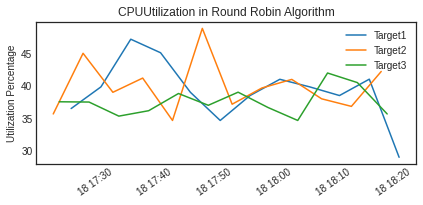

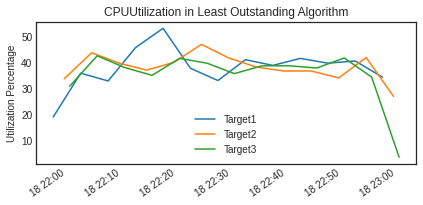

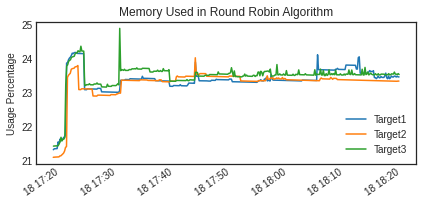

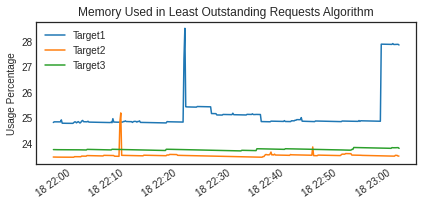

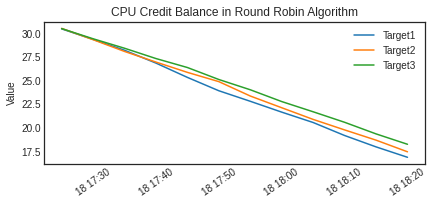

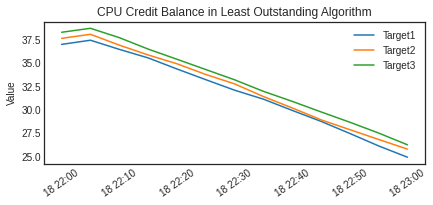

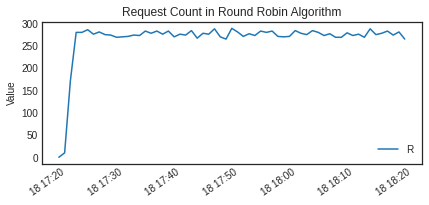

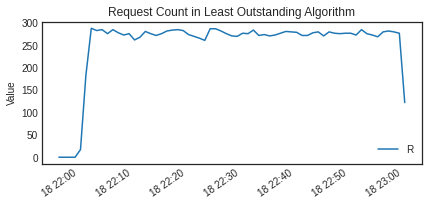

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')


plt.figure(figsize=(15,12))
plt.subplot(4,2,1)
plt.plot(CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target1']['Maximum']) 
plt.plot(CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target2']['Maximum'])
plt.plot(CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target3']['Maximum'])
plt.title('CPUUtilization in Round Robin Algorithm')
plt.ylabel('Utilization Percentage')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,2)
plt.plot(CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target1']['Maximum']) 
plt.plot(CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target2']['Maximum'])
plt.plot(CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target3']['Maximum'])
plt.title('CPUUtilization in Least Outstanding Algorithm')
plt.ylabel('Utilization Percentage')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,5)
plt.plot(MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target1']['Maximum']) 
plt.plot(MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target2']['Maximum'])
plt.plot(MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target3']['Maximum'])
plt.title('Memory Used in Round Robin Algorithm')
plt.ylabel('Usage Percentage')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,6)
plt.plot(MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target1']['Maximum']) 
plt.plot(MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target2']['Maximum'])
plt.plot(MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target3']['Maximum'])
plt.title('Memory Used in Least Outstanding Requests Algorithm')
plt.ylabel('Usage Percentage')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,3)
plt.plot(CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target1']['Maximum']) 
plt.plot(CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target2']['Maximum'])
plt.plot(CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target3']['Maximum'])
plt.title('CPU Credit Balance in Round Robin Algorithm')
plt.ylabel('Value')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,4)
plt.plot(CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target1']['Maximum']) 
plt.plot(CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target2']['Maximum'])
plt.plot(CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target3']['Maximum'])
plt.title('CPU Credit Balance in Least Outstanding Algorithm')
plt.ylabel('Value')
plt.xticks(rotation=35)
plt.legend(targets)


plt.figure(figsize=(15,12))
plt.subplot(4,2,7)
plt.plot(RequestCount_RRB['Sum']) 
plt.title('Request Count in Round Robin Algorithm')
plt.ylabel('Value')
plt.xticks(rotation=35)
plt.legend('Request Count')


plt.figure(figsize=(15,12))
plt.subplot(4,2,8)
plt.plot(RequestCount_LOS['Sum']) 
plt.title('Request Count in Least Outstanding Algorithm')
plt.ylabel('Value')
plt.xticks(rotation=35)
plt.legend('Request Count')

plt.show()

Result -1 


1.   It is clearly evident that Memory utilization of Target1 is high compared to other targets in Least Outstanding Algorithm
2.   Maximum CPU Utilization of Target 1 is relatively high compared to other targets in Round-robin algorithm
3.   It is concluded that Round-robin algorithm performs better than least outstanding algorithm in efficently utilizing the targets for this workload

Conclusion - **Round-robin is better choice for this workload**



## Workload wise Analysis

In [38]:
ELB_RRB.groupby(['Target', 'WorkLoad_Type'])['Completion_Time'].describe()


count       mean       std  ...     50%       75%     max
Target  WorkLoad_Type                               ...                          
Target1 calculate      1711.0   0.002108  0.002047  ...   0.001   0.00200   0.019
        consume        1825.0  10.011989  0.004382  ...  10.011  10.01300  10.038
        sleep          1771.0  55.011320  3.407448  ...  55.048  58.03250  60.084
Target2 calculate      1824.0   0.002180  0.002114  ...   0.001   0.00200   0.024
        consume        1783.0  10.011886  0.004863  ...  10.011  10.01300  10.071
        sleep          1704.0  55.093683  3.192264  ...  55.054  58.03925  60.077
Target3 calculate      1782.0   0.002269  0.001933  ...   0.002   0.00200   0.015
        consume        1696.0  10.009538  0.087987  ...  10.011  10.01300  10.036
        sleep          1843.0  55.030186  3.152166  ...  55.041  58.03950  60.082

[9 rows x 8 columns]

In [39]:
ELB_LOS.groupby(['Target', 'WorkLoad_Type'])['Completion_Time'].describe()


count       mean       std  ...      50%     75%     max
Target  WorkLoad_Type                               ...                         
Target1 calculate      1850.0   0.001835  0.002430  ...   0.0010   0.001   0.033
        consume        1803.0  10.012057  0.004904  ...  10.0110  10.014  10.051
        sleep          1813.0  54.947558  3.034662  ...  55.0440  57.063  60.078
Target2 calculate      1822.0   0.003797  0.086439  ...   0.0010   0.001   3.690
        consume        1808.0  10.007117  0.201629  ...  10.0110  10.014  10.055
        sleep          1810.0  54.946365  3.437671  ...  55.0395  58.035  60.090
Target3 calculate      1759.0   0.002581  0.002097  ...   0.0020   0.002   0.026
        consume        1804.0  10.012340  0.004603  ...  10.0110  10.014  10.055
        sleep          1809.0  55.055368  3.126145  ...  55.0450  58.029  60.077

[9 rows x 8 columns]

Result 2:


1.   Maximum Completion Time for workload types calculate and consume has been increased in Least outstanding request algorithm compared to round-robin algorithm
2.   Maximum completion time for sleep workload type is slightly increased in round-robin lgorithm for 2 targets 

Conclusion - This results confirms further that **Round-robin algorithm performs better** in efficiently utilizing the resources for routing the requests


## Data Generation for RL Observation space

Based on Result 1 and Result 2 - Roun-robin algorithm is best choice for this workload. Hence Data for observation space is generated from Round-robin dataset

In [41]:

### Upsampling Memory used , CPU Utilization , CPU Credit Balance for individual targets for Round Robin Algorithm results

MemoryUsedRRB_Target1 = MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target1']
MemoryUsedRRB_Target1 = MemoryUsedRRB_Target1.resample('S').sum()
MemoryUsedRRB_Target1['Maximum'] = MemoryUsedRRB_Target1['Maximum'].replace(0.0, np.NaN)
MemoryUsedRRB_Target1 = MemoryUsedRRB_Target1.interpolate(method='linear')

MemoryUsedRRB_Target2 = MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target2']
MemoryUsedRRB_Target2 = MemoryUsedRRB_Target2.resample('S').sum()
MemoryUsedRRB_Target2['Maximum'] = MemoryUsedRRB_Target2['Maximum'].replace(0.0, np.NaN)
MemoryUsedRRB_Target2 = MemoryUsedRRB_Target2.interpolate(method='linear')

MemoryUsedRRB_Target3 = MemoryUsedRRB.loc[MemoryUsedRRB['Target'] == 'Target3']
MemoryUsedRRB_Target3 = MemoryUsedRRB_Target3.resample('S').sum()
MemoryUsedRRB_Target3['Maximum'] = MemoryUsedRRB_Target3['Maximum'].replace(0.0, np.NaN)
MemoryUsedRRB_Target3 = MemoryUsedRRB_Target3.interpolate(method='linear')

CPUUtilization_RRB_Target1 = CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target1']
CPUUtilization_RRB_Target1 = CPUUtilization_RRB_Target1.resample('S').sum()
CPUUtilization_RRB_Target1['Maximum'] = CPUUtilization_RRB_Target1['Maximum'].replace(0.0, np.NaN)
CPUUtilization_RRB_Target1 = CPUUtilization_RRB_Target1.interpolate(method='linear')

CPUUtilization_RRB_Target2 = CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target2']
CPUUtilization_RRB_Target2 = CPUUtilization_RRB_Target2.resample('S').sum()
CPUUtilization_RRB_Target2['Maximum'] = CPUUtilization_RRB_Target2['Maximum'].replace(0.0, np.NaN)
CPUUtilization_RRB_Target2 = CPUUtilization_RRB_Target2.interpolate(method='linear')

CPUUtilization_RRB_Target3 = CPUUtilization_RRB.loc[CPUUtilization_RRB['Target'] == 'Target3']
CPUUtilization_RRB_Target3 = CPUUtilization_RRB_Target3.resample('S').sum()
CPUUtilization_RRB_Target3['Maximum'] = CPUUtilization_RRB_Target3['Maximum'].replace(0.0, np.NaN)
CPUUtilization_RRB_Target3 = CPUUtilization_RRB_Target3.interpolate(method='linear')

CPUCreditBalance_RRB_Target1 = CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target1']
CPUCreditBalance_RRB_Target1 = CPUCreditBalance_RRB_Target1.resample('S').sum()
CPUCreditBalance_RRB_Target1['Maximum'] = CPUCreditBalance_RRB_Target1['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_RRB_Target1 = CPUCreditBalance_RRB_Target1.interpolate(method='linear')


CPUCreditBalance_RRB_Target2 = CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target2']
CPUCreditBalance_RRB_Target2 = CPUCreditBalance_RRB_Target2.resample('S').sum()
CPUCreditBalance_RRB_Target2['Maximum'] = CPUCreditBalance_RRB_Target2['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_RRB_Target2 = CPUCreditBalance_RRB_Target2.interpolate(method='linear')

CPUCreditBalance_RRB_Target3 = CPUCreditBalance_RRB.loc[CPUCreditBalance_RRB['Target'] == 'Target3']
CPUCreditBalance_RRB_Target3 = CPUCreditBalance_RRB_Target3.resample('S').sum()
CPUCreditBalance_RRB_Target3['Maximum'] = CPUCreditBalance_RRB_Target3['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_RRB_Target3 = CPUCreditBalance_RRB_Target3.interpolate(method='linear')

In [229]:

### Upsampling Memory used , CPU Utilization , CPU Credit Balance for individual targets for Round Robin Algorithm results

MemoryUsedLOS_Target1 = MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target1']
MemoryUsedLOS_Target1 = MemoryUsedLOS_Target1.resample('S').sum()
MemoryUsedLOS_Target1['Maximum'] = MemoryUsedLOS_Target1['Maximum'].replace(0.0, np.NaN)
MemoryUsedLOS_Target1 = MemoryUsedLOS_Target1.interpolate(method='linear')

MemoryUsedLOS_Target2 = MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target2']
MemoryUsedLOS_Target2 = MemoryUsedLOS_Target2.resample('S').sum()
MemoryUsedLOS_Target2['Maximum'] = MemoryUsedLOS_Target2['Maximum'].replace(0.0, np.NaN)
MemoryUsedLOS_Target2 = MemoryUsedLOS_Target2.interpolate(method='linear')

MemoryUsedLOS_Target3 = MemoryUsedLOS.loc[MemoryUsedLOS['Target'] == 'Target3']
MemoryUsedLOS_Target3 = MemoryUsedLOS_Target3.resample('S').sum()
MemoryUsedLOS_Target3['Maximum'] = MemoryUsedLOS_Target3['Maximum'].replace(0.0, np.NaN)
MemoryUsedLOS_Target3 = MemoryUsedLOS_Target3.interpolate(method='linear')

CPUUtilization_LOS_Target1 = CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target1']
CPUUtilization_LOS_Target1 = CPUUtilization_LOS_Target1.resample('S').sum()
CPUUtilization_LOS_Target1['Maximum'] = CPUUtilization_LOS_Target1['Maximum'].replace(0.0, np.NaN)
CPUUtilization_LOS_Target1 = CPUUtilization_LOS_Target1.interpolate(method='linear')

CPUUtilization_LOS_Target2 = CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target2']
CPUUtilization_LOS_Target2 = CPUUtilization_LOS_Target2.resample('S').sum()
CPUUtilization_LOS_Target2['Maximum'] = CPUUtilization_LOS_Target2['Maximum'].replace(0.0, np.NaN)
CPUUtilization_LOS_Target2 = CPUUtilization_LOS_Target2.interpolate(method='linear')

CPUUtilization_LOS_Target3 = CPUUtilization_LOS.loc[CPUUtilization_LOS['Target'] == 'Target3']
CPUUtilization_LOS_Target3 = CPUUtilization_LOS_Target3.resample('S').sum()
CPUUtilization_LOS_Target3['Maximum'] = CPUUtilization_LOS_Target3['Maximum'].replace(0.0, np.NaN)
CPUUtilization_LOS_Target3 = CPUUtilization_LOS_Target3.interpolate(method='linear')

CPUCreditBalance_LOS_Target1 = CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target1']
CPUCreditBalance_LOS_Target1 = CPUCreditBalance_LOS_Target1.resample('S').sum()
CPUCreditBalance_LOS_Target1['Maximum'] = CPUCreditBalance_LOS_Target1['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_LOS_Target1 = CPUCreditBalance_LOS_Target1.interpolate(method='linear')


CPUCreditBalance_LOS_Target2 = CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target2']
CPUCreditBalance_LOS_Target2 = CPUCreditBalance_LOS_Target2.resample('S').sum()
CPUCreditBalance_LOS_Target2['Maximum'] = CPUCreditBalance_LOS_Target2['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_LOS_Target2 = CPUCreditBalance_LOS_Target2.interpolate(method='linear')

CPUCreditBalance_LOS_Target3 = CPUCreditBalance_LOS.loc[CPUCreditBalance_LOS['Target'] == 'Target3']
CPUCreditBalance_LOS_Target3 = CPUCreditBalance_LOS_Target3.resample('S').sum()
CPUCreditBalance_LOS_Target3['Maximum'] = CPUCreditBalance_LOS_Target3['Maximum'].replace(0.0, np.NaN)
CPUCreditBalance_LOS_Target3 = CPUCreditBalance_LOS_Target3.interpolate(method='linear')

In [230]:
## Join datasets based on time series index

Targets_RRB =  MemoryUsedRRB_Target1.join(MemoryUsedRRB_Target2, how='outer', lsuffix='_Target1_Memory_Used', 
                                          rsuffix='_Target2_Memory_Used').join(MemoryUsedRRB_Target3, how='outer').join(CPUUtilization_RRB_Target1, how='outer', lsuffix='_Target3_Memory_Used',
                                                        rsuffix='_Target1_CPU_Utilization').join(CPUUtilization_RRB_Target2, how='outer').join(CPUUtilization_RRB_Target3 , how='outer', lsuffix = '_Target2_CPU_Utilization', 
                                                                  rsuffix= '_Target3_CPU_Utilization')

In [231]:
## Join datasets based on time series index

Targets_LOS =  MemoryUsedLOS_Target1.join(MemoryUsedLOS_Target2, how='outer', lsuffix='_Target1_Memory_Used', 
                                          rsuffix='_Target2_Memory_Used').join(MemoryUsedLOS_Target3, how='outer').join(CPUUtilization_LOS_Target1, how='outer', lsuffix='_Target3_Memory_Used',
                                                        rsuffix='_Target1_CPU_Utilization').join(CPUUtilization_LOS_Target2, how='outer').join(CPUUtilization_LOS_Target3 , how='outer', lsuffix = '_Target2_CPU_Utilization', 
                                                                  rsuffix= '_Target3_CPU_Utilization')

In [43]:
RRB = Targets_RRB.join(ELB_RRB[['WorkLoad_Type']], how='outer')

In [44]:
## Fetch only a subset from the larger dataset


mask = (RRB.index > '2021-01-18 17:27:00') & (RRB.index <= '2021-01-18 18:15:00')
print(mask)
RRB = RRB.loc[mask]

[False False False ... False False False]


In [45]:
RRB = RRB[RRB['WorkLoad_Type'].notna()]

In [46]:
## Label Encoding Workload type
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
RRB['WorkLoad_Type'].unique()

RRB['WorkLoad_Type']= le.fit_transform(RRB['WorkLoad_Type'])
print(le.classes_) 

['calculate' 'consume' 'sleep']


In [47]:
### Observation Space

timestepsRRB = RRB.to_numpy()

In [48]:
### Reference Memory and CPU Consumption from Round-robin algorithm
MemoryDelta = (0.437761 + 0.459785 + 0.422949)/3
CPUDelta = (3.430449 + 2.636848 + 1.699964)/3

## Reinforcement Learning Approach

Python based Environment for Reinforcement learning 

In [120]:
class AWSELBEnv(py_environment.PyEnvironment):

    def __init__(self):
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=2, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(7,), dtype=np.float64,  minimum=np.array([0, 0, 0, 0, 0, 0, 0]), name='observation')
        self._state=np.array([20, 20, 20, 10, 10, 10, 0]) #represent the (current state, workload type) 
        self._episode_ended = False
        self.targets=['172.31.44.201', '172.31.42.62', '172.31.9.156']
        timeRRB = timestepsRRB

        
      
    def _reset(self):
        randState = random.randint(0,13000)
        self._state=timestepsRRB[randState,:]
        self._episode_ended = False
        return ts.restart(np.array(self._state, dtype=np.float64))
      
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec      
    
       
    def _step(self, action):
        if self._episode_ended:
            return self.reset()
        if action == 0:                      
            #if ((self._state[0]+ 1*MemoryDelta) < self._state[1]) and ((self._state[0]+ 1*MemoryDelta) < self._state[2]) and ((self._state[3]+ 1*CPUDelta) < self._state[4]) and ((self._state[3]+ 1*CPUDelta) < self._state[5]):
            if ((self._state[0]) < self._state[1]) and ((self._state[0]) < self._state[2]) and ((self._state[3]) < self._state[4]) and ((self._state[3]) < self._state[5]):
                reward = 1
            else:
                reward = 0
            self._episode_ended = True
        elif action == 1:            
            #if ((self._state[1]+ 1*MemoryDelta) < self._state[0]) and ((self._state[1]+ 1*MemoryDelta) < self._state[2]) and ((self._state[4]+ 1*CPUDelta) < self._state[3]) and ((self._state[4]+ 1*CPUDelta) < self._state[5]):
            if ((self._state[1]) < self._state[0]) and ((self._state[1]) < self._state[2]) and ((self._state[4]) < self._state[3]) and ((self._state[4]) < self._state[5]):
                reward = 1
            else:
                reward = 0
            self._episode_ended = True          
        else:            
            #if ((self._state[2]+ 1*MemoryDelta) < self._state[1]) and ((self._state[2]+ 1*MemoryDelta) < self._state[0]) and ((self._state[5]+ 1*CPUDelta) < self._state[4]) and ((self._state[5]+ 1*CPUDelta) < self._state[3]):
            if ((self._state[2]) < self._state[1]) and ((self._state[2]) < self._state[0]) and ((self._state[5]) < self._state[4]) and ((self._state[5]) < self._state[3]):
                reward = 1
            else:
                reward = 0
            self._episode_ended = True
        if self._episode_ended:
            return ts.termination(self._state, reward)
        
   
    

In [121]:
# Training and Evaluatio environment creation 
train_py_env = AWSELBEnv()
eval_py_env = AWSELBEnv()

In [122]:
# Converting python environment with tensorflow environment

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [210]:
## Setting Hyperparameters

num_iterations = 8500 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval =   2000# @param {type:"integer"}

In [181]:
## Defining Q-Network

fc_layer_params = (400,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [182]:
## Initializing optimizer for DQN Agent

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [183]:
## setting training step counter

train_step_counter = tf.Variable(0)

In [184]:
## Instantiating DQN Agent
agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

In [185]:
## Declaring Evaluation and Collection policy

eval_policy = agent.policy
collect_policy = agent.collect_policy

In [186]:
## Random Policy Generator

random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [187]:
## Calculate Reward for selected policy 

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [188]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

0.11

In [189]:
## Set up Replay Buffer to store the experience

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [190]:
## Collect data and store it as trajectory for agent's neural network training

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(train_env.current_time_step())
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, initial_collect_steps)

In [191]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 7), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float64, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [211]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  
  collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  #print(experience)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  #if step % log_interval == 0:
    #print('loss = {0}'.format(train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('Return = {0}'.format(avg_return))
    returns.append(avg_return)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs
Return = 0.30000001192092896
Return = 0.5
Return = 0.5
Return = 0.6000000238418579


## RL Results and comparision

Average rewards received during the training process

[0.5, 0.3, 0.5, 0.5, 0.6]
range(0, 8501, 2000)


(0.2850000113248825, 0.8)

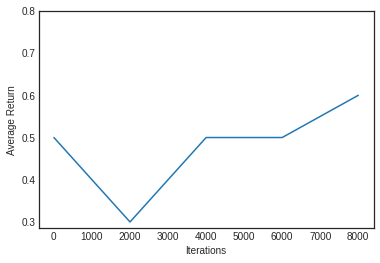

In [213]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
print(returns)
print(iterations)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=0.8)

Applying rewards process to the data generated from Round robin algorithm for comparision against RL rewards

In [219]:
## Setting up dataframe for reward calculation in RRB


RRB_vs_RL = Targets_RRB.join(ELB_RRB[['WorkLoad_Type', 'Target']], how='outer')
## Fetch only a subset from the larger dataset
mask = (RRB_vs_RL.index > '2021-01-18 17:27:00') & (RRB_vs_RL.index <= '2021-01-18 18:15:00')
RRB_vs_RL = RRB_vs_RL.loc[mask]

RRB_vs_RL = RRB_vs_RL[RRB_vs_RL['WorkLoad_Type'].notna()]




In [221]:
## Calculate Reward Function 

def calculateRewards(Maximum_Target1_Memory_Used, Maximum_Target2_Memory_Used, Maximum_Target3_Memory_Used, Maximum_Target1_CPU_Utilization, Maximum_Target2_CPU_Utilization, Maximum_Target3_CPU_Utilization, WorkLoad_Type,Target):
  if Target == 'Target1':
    if ((Maximum_Target1_Memory_Used) < Maximum_Target2_Memory_Used) and ((Maximum_Target1_Memory_Used) < Maximum_Target3_Memory_Used) and ((Maximum_Target1_CPU_Utilization) < Maximum_Target2_CPU_Utilization) and ((Maximum_Target1_CPU_Utilization) < Maximum_Target1_CPU_Utilization):
      reward = 1
    else:
      reward = 0
  elif Target == 'Target2':
    if ((Maximum_Target2_Memory_Used) < Maximum_Target1_Memory_Used) and ((Maximum_Target2_Memory_Used) < Maximum_Target3_Memory_Used) and ((Maximum_Target2_CPU_Utilization) < Maximum_Target1_CPU_Utilization) and ((Maximum_Target2_CPU_Utilization) < Maximum_Target3_CPU_Utilization):
      reward = 1
    else:
      reward = 0
  elif Target == 'Target3':
    if ((Maximum_Target3_Memory_Used) < Maximum_Target1_Memory_Used) and ((Maximum_Target3_Memory_Used) < Maximum_Target2_Memory_Used) and ((Maximum_Target3_CPU_Utilization) < Maximum_Target1_CPU_Utilization) and ((Maximum_Target3_CPU_Utilization) < Maximum_Target2_CPU_Utilization):
      reward = 1
    else:
      reward = 0
  return reward 



In [222]:
RRB_vs_RL['Rewards'] =  RRB_vs_RL.apply(lambda x: calculateRewards(x.Maximum_Target1_Memory_Used, x.Maximum_Target2_Memory_Used, 
                                                            x.Maximum_Target3_Memory_Used, x.Maximum_Target1_CPU_Utilization, 
                                                            x.Maximum_Target2_CPU_Utilization, x.Maximum_Target3_CPU_Utilization, x. WorkLoad_Type,x.Target), axis=1)

In [226]:
## Average Reward Score for RRB

RRB_vs_RL['Rewards'].mean()

0.0673352435530086

In [235]:

## Setting up dataframe for reward calculation in LOS
LOS_vs_RL = Targets_LOS.join(ELB_LOS[['WorkLoad_Type', 'Target']], how='outer')
LOS_vs_RL
## Fetch only a subset from the larger dataset
mask = (LOS_vs_RL.index > '2021-01-18 22:05:00') & (LOS_vs_RL.index <= '2021-01-18 22:55:00')
LOS_vs_RL = LOS_vs_RL.loc[mask]

LOS_vs_RL = LOS_vs_RL[LOS_vs_RL['WorkLoad_Type'].notna()]

In [237]:
LOS_vs_RL['Rewards'] =  LOS_vs_RL.apply(lambda x: calculateRewards(x.Maximum_Target1_Memory_Used, x.Maximum_Target2_Memory_Used, 
                                                            x.Maximum_Target3_Memory_Used, x.Maximum_Target1_CPU_Utilization, 
                                                            x.Maximum_Target2_CPU_Utilization, x.Maximum_Target3_CPU_Utilization, x. WorkLoad_Type,x.Target), axis=1)

In [238]:
## Average Reward Score for LOS
LOS_vs_RL['Rewards'].mean()

0.12039187227866473

Result 3:



1.   Average Rewards - Reinforcement Learning : 0.60
2.   Average Rewards - Round-robin Algorithm  : 0.067
3.   Average Rewards - Least Outstanding Requests Algorithm  : 0.120

**Conclusion:-  Reinforcement Learning agent is performing best by large margin in effiectively utilizing the virtual machines resources.**

